In [1]:
import json
import pandas as pd
import re
import numpy as np


pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 15)

keep_metrics = ['HV', 'spread', 'gdplus', 'unfr']
datasets_names = ['p1', 'p2', 'a1', 'a2', 'a3', 'a4', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6']

       


### 0. Datasets insight

In [16]:
import sys  
sys.path.insert(0, '../datasets')
from Dataset import Dataset

ds_summary = pd.DataFrame(columns=['Dataset', '#Stakeholders', '#PBI', '#(PBI-->[PBI])', '%(PBI-->[PBI])','Avg_len[PBI]'])

for name in datasets_names:
    ds = Dataset(source_file='..\datasets\\'+ name+ '.json')
    n_pbis = ds.num_pbis
    n_stakeholders = len(ds.stakeholders_importances)

    n_dependencies = sum(x is not None for x in ds.dependencies)
    ratio_pbi_with_deps =  n_dependencies / n_pbis
    avg_depends_per_pbi = 0
    for dep in ds.dependencies:
        avg_depends_per_pbi = avg_depends_per_pbi + len(dep) if dep is not None else avg_depends_per_pbi + 0
    avg_depends_per_pbi = avg_depends_per_pbi / n_dependencies

    new_row = {'Dataset': name, '#Stakeholders': n_stakeholders, '#PBI': n_pbis,  '#(PBI-->[PBI])': n_dependencies, '%(PBI-->[PBI])': ratio_pbi_with_deps, 'Avg_len[PBI]':avg_depends_per_pbi}
    ds_summary = ds_summary.append(new_row, ignore_index=True)

display(ds_summary)








,Dataset,#Stakeholders,#PBI,#(PBI-->[PBI]),%(PBI-->[PBI]),Avg_len[PBI]
0,p1,5,20,7,0.350,1.857143
1,p2,5,100,29,0.290,2.689655
2,a1,5,50,18,0.360,2.222222
3,a2,15,50,18,0.360,2.722222
4,a3,5,200,74,0.370,1.945946
5,a4,15,200,75,0.375,2.253333
6,c1,15,50,20,0.400,2.400000
7,c2,100,50,17,0.340,3.529412
8,c3,15,200,69,0.345,1.942029
9,c4,100,200,75,0.375,2.093333


In [2]:
def getdf_with_params_and_metrics(files, keep_parameters):

    parameters_dictios_list = []
    metrics_dictios_list = []
    
    for file in files:
        with open(file, 'r') as f:
            dictio = json.load(f)
            parameters_dictios_list.append(dictio['parameters'])
            metrics_dictios_list.append(dictio['metrics'])
            

    parameters_df= pd.DataFrame(parameters_dictios_list)
    parameters_df = parameters_df[['dataset'] + keep_parameters]

    metrics_df = pd.DataFrame(metrics_dictios_list)
    metrics_df = metrics_df[keep_metrics]
    for column in keep_metrics: #we have several runs for each metric (list of values in each cell), so compute mean
        metrics_df[column] = pd.DataFrame(metrics_df[column].values.tolist()).mean(axis=1)

    combined_df=parameters_df.join(metrics_df)
    combined_df['file']=files

    return combined_df

In [3]:
import pandas as pd
import re

# Counts the number of wins (HV by default) for each configuration in data_df of the given hyperparameters.
# Each win is computed from results for a dataset
# returns:
#    dictionary with the, most frequently, best configuration. if ties, then first occurrence is returned
#    dictionary with the count of configuration which were the best at leats once
#    number of datasets    
# 
def get_best_configuration(data_df, hyperparameters, metric: str = 'HV') -> dict:
    
    dataset_groups = data_df.groupby(['dataset'])
    best_configs_counts = {}


    for group in dataset_groups: # find best hyperparameters config
        #print(group)
        group_df = pd.DataFrame(group[1])
        max_index = group_df[metric].idxmax()
        best_config = (group[1][hyperparameters]).loc[max_index]
        dataset_name = (group[1]['dataset']).loc[max_index] #any row
        file_name = (group[1]['file']).loc[max_index] 
        
        key = best_config.to_string()
        besthv = round(group_df[metric].loc[max_index], 4)
        if key in best_configs_counts.keys():
            (count, list_datasets, list_hv, list_files) = best_configs_counts[key]
            list_datasets.extend([dataset_name])
            list_hv.extend([besthv])
            list_files.extend([file_name])
           
            best_configs_counts[key]= (count + 1, list_datasets, list_hv, list_files)
        else:
            best_configs_counts[key] = (1, [dataset_name], [besthv], [file_name])

           
    
    #print(best_configs_counts)
   # print(len(best_configs_counts))
    #print(best_configs_counts)
    v = list(best_configs_counts.values())
    k = list(best_configs_counts.keys())
    best_config = k[v.index(max(v))]

    #convert string of best config to dictionary 
    best_config = re.sub(' +',' ',best_config)
    best_config = best_config.replace(' ',':')
    best_config = best_config.replace('\n',',')
    best = dict((x.strip(), y.strip())
             for x, y in (element.split(':') 
             for element in best_config.split(',')))
    return best, best_configs_counts, len(dataset_groups)
    
        

In [4]:
# convert dictionary counts of each best configuration to dataframe
def dictionary_keystring_to_dataframe(keep_parameters, best_counts):
    table_df = pd.DataFrame(columns=keep_parameters+['datasets'])
    for k in best_counts.keys():
        #print(f"{k} \n\t\t---> was the best config in: {best_counts[k]} datasets")
        row_dict = dict()
        for col in keep_parameters:
            start=k.index(col+' ')
            try: 
                end=k.index("\n", start)
            except: end = len(k)
            line = k[start:end]
            key = line[0:line.index(' ')]
            value = line[line.rfind(' ')+1:len(line)]
            row_dict[key]=value
        (counts, datasets_names, HVs, file_example) = best_counts[k]
        row_dict['datasets'] = datasets_names
        row_dict['HV'] = HVs
        row_dict['wins'] = int(counts)
        row_dict['file'] = file_example
        table_df = table_df.append(row_dict, ignore_index=True)
    return table_df

In [5]:
def print_hyperparams_values(df, hyperparmeters, algorithm):
    print(f"These are the different values used to set hyperparameters in {algorithm}, for each dataset:")
    mult = 1
    for hp in hyperparmeters:
        values = df[hp].unique()
        mult = mult * len(values)
        print(f"{hp}: {values}")
    print(f"In total, {mult} configuration per dataset.")

## 1. Search of the best hyperparameters configuration for each algorithm.

    1.1 Best configuration for: GRASP


In [13]:
#filest_list_GRASP contains all output files from the GRASP algorithm. Goal is to find the best hyperparameters configuration.
files_container = '../output/filest_list_GRASP'
keep_parameters = ['solutions_per_iteration', 'iterations', 'init_type', 'local_search_type', 'path_relinking_mode']
 

files = []
with open(files_container, 'r') as f:
    for line in f:
        files.append('../'+str(line.replace('\n','')))

df_grasp = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
print_hyperparams_values(df_grasp, keep_parameters, "GRASP")

#display(df_grasp)

best_config_grasp, best_counts, ndatasets= get_best_configuration(data_df=df_grasp, hyperparameters=keep_parameters, metric='HV')
best_for_grasp_df=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)

print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
    "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
    "can be interpreted as 'minimum configuration to converge'.")

display(best_for_grasp_df.drop(['file'], axis=1, inplace=False))


print(f"\nBest hyperparameter configuration for GRASP is:")
for param in best_config_grasp:
    print(f"{param}:{best_config_grasp[param]}")




FileNotFoundError: [Errno 2] No such file or directory: '../output/filest_list_GRASP'

    1.2 Best configuration for: GeneticNDS


In [6]:
# files_container contains all output files from the geneticNDS algorithm. Goal is to find the best hyperparameters configuration.
files_container = '../output/filest_list_geneticnds'
keep_parameters = ['population_length', 'max_generations', 'selection_candidates', 'crossover_prob', 'mutation_prob', 'mutation', 'replacement']


files = []
with open(files_container, 'r') as f:
    for line in f:
        files.append('../'+str(line.replace('\n','')))

df_genetic = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
print_hyperparams_values(df_genetic, keep_parameters, "GeneticNDS")

#display(df_genetic)
best_config_geneticNDS, best_counts, ndatasets= get_best_configuration(data_df=df_genetic, hyperparameters=keep_parameters, metric='HV')
best_for_geneticnds_df=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)


print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
    "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
    "can be interpreted as 'minimum configuration to converge'.")
display(best_for_geneticnds_df.drop(['file'], axis=1, inplace=False))

print(f"\nBest hyperparameter configuration for GeneticNDS is:")
for param in best_config_geneticNDS:
    print(f"{param}:{best_config_geneticNDS[param]}")

        



These are the different values used to set hyperparameters in GeneticNDS, for each dataset:
population_length: [ 100  200  500  700 1000]
max_generations: [ 50 100 200 300 400]
selection_candidates: [2]
crossover_prob: [0.8]
mutation_prob: [0.1 0.3]
mutation: ['flip1bit']
replacement: ['elitismnds']
In total, 50 configuration per dataset.

Counts of best configurations found in 12 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,population_length,max_generations,selection_candidates,crossover_prob,mutation_prob,mutation,replacement,datasets,HV,wins
0,1000,50,2,0.8,0.3,flip1bit,elitismnds,"[a1, p2]","[0.4806, 0.6829]",2.0
1,1000,300,2,0.8,0.3,flip1bit,elitismnds,"[a2, c3, c4, c6]","[0.3983, 0.4268, 0.2547, 0.2407]",4.0
2,1000,400,2,0.8,0.3,flip1bit,elitismnds,"[a3, a4]","[0.5233, 0.3367]",2.0
3,1000,200,2,0.8,0.3,flip1bit,elitismnds,"[c1, c5]","[0.5303, 0.5066]",2.0
4,1000,300,2,0.8,0.1,flip1bit,elitismnds,[c2],[0.2196],1.0
5,1000,200,2,0.8,0.1,flip1bit,elitismnds,[p1],[0.5851],1.0



Best hyperparameter configuration for GeneticNDS is:
population_length:1000
max_generations:300
selection_candidates:2
crossover_prob:0.8
mutation_prob:0.3
mutation:flip1bit
replacement:elitismnds


    1.3 Best configuration for: NSGAii


In [ ]:
print("pending to solve deepcopy issue....")

pending to solve deepcopy issue....


    1.4 Best configuration for: UMDA



In [7]:
# Liles_container' contains all output files from the UMDA algorithm. Goal is to find the best hyperparameters configuration.
keep_parameters = ['population_length', 'max_generations', 'selection_scheme', 'replacement_scheme']

files_container = '../output/filest_list_umda'

files = []
with open(files_container, 'r') as f:
    for line in f:
        files.append('../'+str(line.replace('\n','')))

df_umda = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
print_hyperparams_values(df_umda, keep_parameters, "UMDA")
#display(df_umda)
best_config_umda, best_counts, ndatasets= get_best_configuration(data_df=df_umda, hyperparameters=keep_parameters, metric='HV')
best_for_umda_df=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)


print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
    "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
    "can be interpreted as 'minimum configuration to converge'.")
display(best_for_umda_df.drop(['file'], axis=1, inplace=False))

print(f"\nBest hyperparameter configuration for UMDA is:")
for param in best_config_umda:
    print(f"{param}:{best_config_umda[param]}")

These are the different values used to set hyperparameters in UMDA, for each dataset:
population_length: [ 100  200  500  700 1000]
max_generations: [ 50 100 200 300 400]
selection_scheme: ['nds']
replacement_scheme: ['elitism']
In total, 25 configuration per dataset.

Counts of best configurations found in 12 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,population_length,max_generations,selection_scheme,replacement_scheme,datasets,HV,wins
0,1000,50,nds,elitism,[a1],[0.8686],1.0
1,1000,300,nds,elitism,[a2],[0.9385],1.0
2,1000,200,nds,elitism,"[a3, a4, c2, c5]","[0.8036, 0.7956, 0.8782, 0.8309]",4.0
3,1000,400,nds,elitism,"[c1, c4, c6]","[0.8926, 0.8225, 0.8314]",3.0
4,1000,100,nds,elitism,"[c3, p1, p2]","[0.8741, 0.9061, 0.7763]",3.0



Best hyperparameter configuration for UMDA is:
population_length:1000
max_generations:200
selection_scheme:nds
replacement_scheme:elitism


    1.5 Best configuration for: PBIL


In [8]:
keep_parameters = ['population_length', 'max_generations','max_evaluations', 'learning_rate', 'mutation_prob','mutation_shift']
files_container = '../output/filest_list_pbil'

files = []
with open(files_container, 'r') as f:
    for line in f:
        files.append('../'+str(line.replace('\n','')))

df_pbil = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
print_hyperparams_values(df_pbil, keep_parameters, "PBIL")
#display(df_pbil)
best_config_pbil, best_counts, ndatasets= get_best_configuration(data_df=df_pbil, hyperparameters=keep_parameters, metric='HV')
best_for_pbil_df=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)


print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
    "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
    "can be interpreted as 'minimum configuration to converge'.")
display(best_for_pbil_df.drop(['file'], axis=1, inplace=False))

print(f"\nBest hyperparameter configuration for PBIL is:")
for param in best_config_pbil:
    print(f"{param}:{best_config_pbil[param]}")







These are the different values used to set hyperparameters in PBIL, for each dataset:
population_length: [ 100  200  500  700 1000]
max_generations: [ 50 100 200 300 400]
max_evaluations: [0]
learning_rate: [0.1]
mutation_prob: [0.1]
mutation_shift: [0.1]
In total, 25 configuration per dataset.

Counts of best configurations found in 12 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,population_length,max_generations,max_evaluations,learning_rate,mutation_prob,mutation_shift,datasets,HV,wins
0,1000.0,400.0,0.0,0.1,0.1,0.1,"[a1, a3, c1, c4, c5, c6, p1]","[0.8309, 0.7059, 0.8453, 0.7254, 0.7373, 0.751...",7.0
1,1000.0,300.0,0.0,0.1,0.1,0.1,"[a2, a4, p2]","[0.8994, 0.6832, 0.6747]",3.0
2,1000.0,100.0,0.0,0.1,0.1,0.1,[c2],[0.8106],1.0
3,700.0,400.0,0.0,0.1,0.1,0.1,[c3],[0.8331],1.0



Best hyperparameter configuration for PBIL is:
population_length:1000.0
max_generations:400.0
max_evaluations:0.0
learning_rate:0.1
mutation_prob:0.1
mutation_shift:0.1


    1.6 Best configuration for: FEDA


In [21]:
keep_parameters = ['population_length', 'max_generations','max_evaluations', 'selection_scheme']

files_container = '../output/filest_list_feda'


files = []
with open(files_container, 'r') as f:
    for line in f:
        files.append('../'+str(line.replace('\n','')))

df_feda = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
print_hyperparams_values(df_feda, keep_parameters, "FEDA")
#display(df_feda)
best_config_feda, best_counts, ndatasets= get_best_configuration(data_df=df_feda, hyperparameters=keep_parameters, metric='HV')
best_for_feda_df=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)


print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
    "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
    "can be interpreted as 'minimum configuration to converge'.")
display(best_for_feda_df.drop(['file'], axis=1, inplace=False))

print(f"\nBest hyperparameter configuration for FEDA is:")
for param in best_config_feda:
    print(f"{param}:{best_config_feda[param]}")






These are the different values used to set hyperparameters in FEDA, for each dataset:
population_length: [ 100  200  500  700 1000]
max_generations: [ 50 100 200 300 400]
max_evaluations: [0]
selection_scheme: ['nds']
In total, 25 configuration per dataset.

Counts of best configurations found in 12 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,population_length,max_generations,max_evaluations,selection_scheme,datasets,HV,wins
0,1000,100,0,nds,"[a1, c3, c4, c6]","[0.6972, 0.2838, 0.2981, 0.2213]",4.0000
1,1000,300,0,nds,"[a2, p1, p2]","[0.7151, 0.849, 0.5302]",3.0000
2,1000,50,0,nds,"[a3, c1, c2]","[0.3327, 0.7346, 0.747]",3.0000
3,1000,200,0,nds,[a4],[0.3879],1.0000
4,1000,400,0,nds,[c5],[0.2039],1.0000



Best hyperparameter configuration for FEDA is:
population_length:1000
max_generations:100
max_evaluations:0
selection_scheme:nds


### 2. Pareto plots for each algorithm, set with its best configuration found in the previous section.
Given the most frequently best configuration, we plot the pareto for each dataset given that configuration. 
We show a plot for each dataset. In each plot, for each algorithm, we show the pareto front found in all the executions (commonly 30). Since the solutions subset size is commonly 10, thus for each algorithm we plot 300 points. Since each algorithm has 30 paretos, please note that such paretos are not non-dominated among them, which can be seen in the  shapes they create.

The nearest to point (0,0), the better HV the algorithm has on average (this is just a visual indicator).

Quality metrics gd+ and spread are to be minimized.

Quality metrics HV and UNFR are to be maximized.

Gd+ and UNFR are computed respect to the pareto reference constructed from all configurations for the corresponding algorithm. Thus these metrics should be interpreted as the capacity of each algorithm to find its reference pareto. 


In [10]:
# create list of files with best configuration for a given algorithm
def get_files_list_with_best_configuration(best_for_algorithm_df, datasets_list):
    best_for_algorithm_df['wins'] = best_for_algorithm_df['wins'].astype(int)
    max_index = best_for_algorithm_df['wins'].idxmax()
    file_template = best_for_algorithm_df['file'].loc[max_index][0] #0 or any other if there is more than one file
    dataset_in_template =  best_for_algorithm_df['datasets'].loc[max_index][0]
    algorithm_files = [] #ordered by datasetname
    for dataset in datasets_list:
        file = file_template.replace(dataset_in_template, dataset, 1)
        algorithm_files.extend([file])
    return algorithm_files


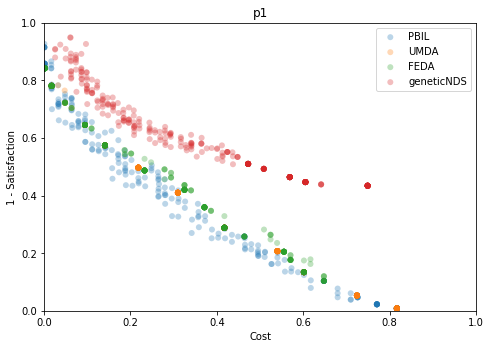

,Method,HV,UNFR,gd+,spread,time(s)
0,PBIL,0.9044,0.0344,0.0373,0.5927,363.4669
1,UMDA,0.8932,0.0001,0.3322,0.6145,313.2548
2,FEDA,0.8464,0.0023,0.3103,0.6266,179.4997
3,geneticNDS,0.5836,0.0183,0.1344,0.6174,519.3005


---------------------------------------------------------------


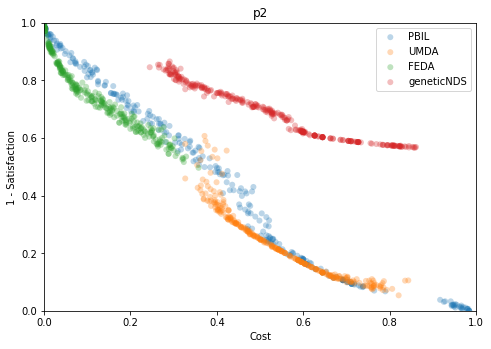

,Method,HV,UNFR,gd+,spread,time(s)
0,PBIL,0.7759,0.0155,0.0094,0.5571,1483.0552
1,UMDA,0.6735,0.0078,0.0236,0.7239,518.4406
2,FEDA,0.5231,0.0143,0.0122,0.5918,566.6815
3,geneticNDS,0.3657,0.2060,0.0009,0.6681,1561.2449


---------------------------------------------------------------


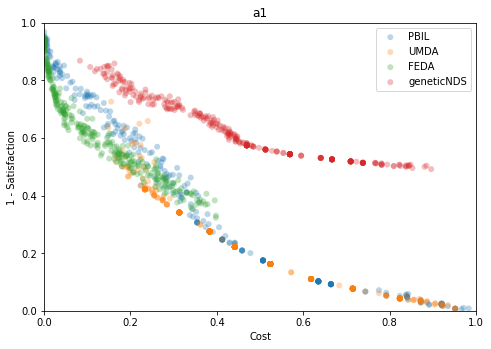

,Method,HV,UNFR,gd+,spread,time(s)
0,PBIL,0.8668,0.0224,0.0383,0.5607,663.6244
1,UMDA,0.8309,0.0045,0.0835,0.5742,324.1230
2,FEDA,0.6972,0.0202,0.0106,0.5936,312.5880
3,geneticNDS,0.4784,0.0130,0.0614,0.6538,846.0065


---------------------------------------------------------------


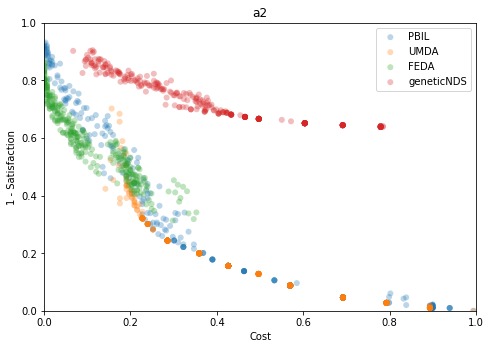

,Method,HV,UNFR,gd+,spread,time(s)
0,PBIL,0.9376,0.0156,0.0568,0.6007,515.6785
1,UMDA,0.8926,0.0070,0.1816,0.6521,257.7775
2,FEDA,0.7057,0.0297,0.0093,0.6247,200.6981
3,geneticNDS,0.3983,0.0153,0.1048,0.6161,414.3803


---------------------------------------------------------------


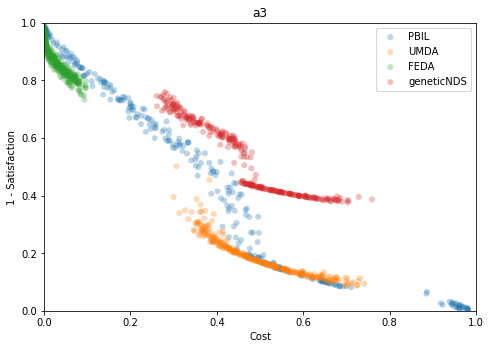

,Method,HV,UNFR,gd+,spread,time(s)
0,PBIL,0.8036,0.0208,0.0084,0.5820,1407.1758
1,UMDA,0.7059,0.0089,0.0164,0.7662,401.5090
2,FEDA,0.3306,0.0123,0.0106,0.6033,375.8692
3,geneticNDS,0.5217,0.0140,0.0114,0.7315,1234.9586


---------------------------------------------------------------


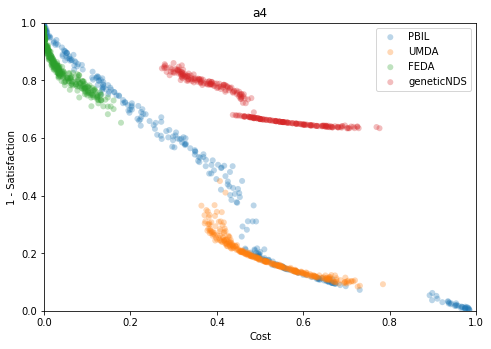

,Method,HV,UNFR,gd+,spread,time(s)
0,PBIL,0.7956,0.0181,0.0059,0.5884,1583.3868
1,UMDA,0.6791,0.0084,0.0157,0.7798,413.6615
2,FEDA,0.3815,0.0162,0.0094,0.5992,471.5598
3,geneticNDS,0.3364,0.0095,0.0221,0.7001,1274.1498


---------------------------------------------------------------


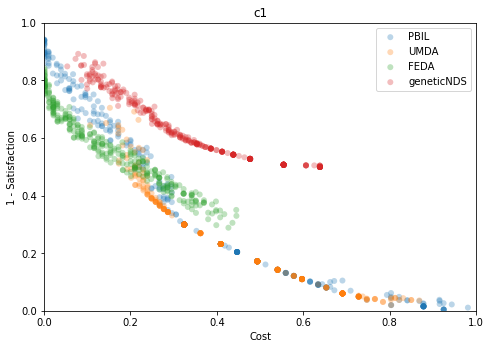

,Method,HV,UNFR,gd+,spread,time(s)
0,PBIL,0.8910,0.0157,0.0431,0.5931,865.7159
1,UMDA,0.8453,0.0056,0.0766,0.6637,400.8913
2,FEDA,0.7274,0.0258,0.0092,0.6225,352.6138
3,geneticNDS,0.5291,0.0102,0.0658,0.6226,1016.7668


---------------------------------------------------------------


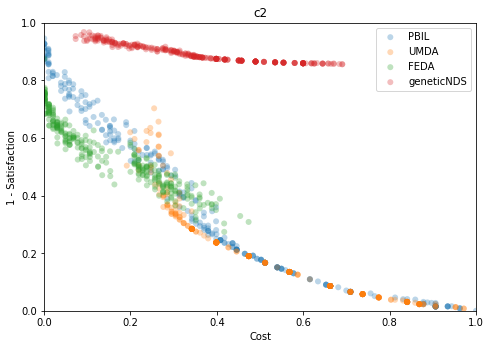

,Method,HV,UNFR,gd+,spread,time(s)
0,PBIL,0.8782,0.0232,0.0306,0.5813,821.5955
1,UMDA,0.8067,0.0118,0.0855,0.6124,381.9937
2,FEDA,0.7283,0.0346,0.0102,0.6682,271.2908
3,geneticNDS,0.2192,0.0048,0.0686,0.6253,977.1027


---------------------------------------------------------------


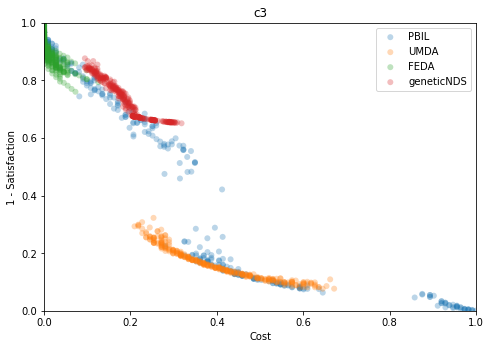

,Method,HV,UNFR,gd+,spread,time(s)
0,PBIL,0.8673,0.0243,0.0069,0.5722,816.8443
1,UMDA,0.8291,0.0080,0.0220,0.7722,325.3016
2,FEDA,0.2838,0.0118,0.0370,0.6778,167.6175
3,geneticNDS,0.4268,0.0087,0.0457,0.7329,805.4917


---------------------------------------------------------------


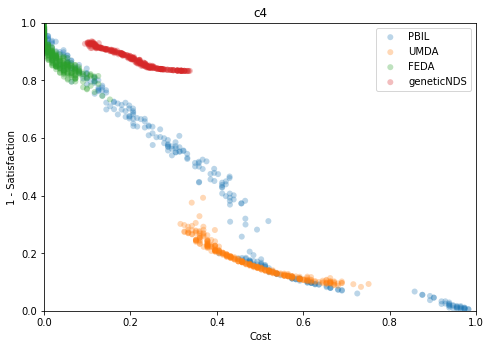

,Method,HV,UNFR,gd+,spread,time(s)
0,PBIL,0.8208,0.0250,0.0078,0.5984,823.7749
1,UMDA,0.7254,0.0081,0.0240,0.7768,364.9257
2,FEDA,0.2981,0.0159,0.0242,0.6491,182.3507
3,geneticNDS,0.2547,0.0052,0.0423,0.7349,850.1039


---------------------------------------------------------------


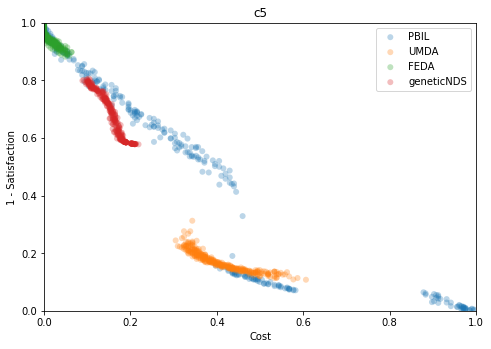

,Method,HV,UNFR,gd+,spread,time(s)
0,PBIL,0.8309,0.0194,0.0062,0.6257,905.7384
1,UMDA,0.7373,0.0111,0.0187,0.8401,441.0463
2,FEDA,0.2016,0.0099,0.0185,0.6686,313.7245
3,geneticNDS,0.5062,0.0077,0.0356,0.7563,794.9068


---------------------------------------------------------------


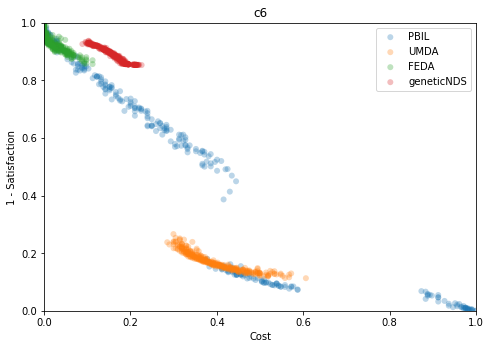

,Method,HV,UNFR,gd+,spread,time(s)
0,PBIL,0.8289,0.0199,0.0064,0.6223,979.3976
1,UMDA,0.7512,0.0082,0.0285,0.8528,391.5978
2,FEDA,0.2213,0.0135,0.0074,0.6327,315.1415
3,geneticNDS,0.2407,0.0064,0.0375,0.7655,766.8289


---------------------------------------------------------------


In [23]:
from pymoo.visualization.scatter import Scatter
import matplotlib.pyplot as plt

algorithms = ['PBIL', 'UMDA', 'FEDA','geneticNDS'] #['geneticNDS', 'UMDA', 'PBIL', 'GRASP', 'FEDA']
#display(best_for_grasp_df)

files_all_algorithms =[
   
    
    get_files_list_with_best_configuration(best_for_umda_df,datasets_names),
    get_files_list_with_best_configuration(best_for_pbil_df,datasets_names),
    #get_files_list_with_best_configuration(best_for_grasp_df,datasets),
    get_files_list_with_best_configuration(best_for_feda_df,datasets_names),
    get_files_list_with_best_configuration(best_for_geneticnds_df,datasets_names),
] 

# print 30 (or the number of execution) paretos of each dataset
# (maybe one plot per dataset, and all differente algorithms in each plot)
for i in range(0,len(datasets_names)):
    fig = plt.figure()
    ax =fig.add_axes([0,0,1,1])
    ax.set_xlabel('Cost')
    ax.set_ylabel('1 - Satisfaction')
    ax.set_title(datasets_names[i])
    plt.xlim([0,1])
    plt.ylim([0,1])
    
    summary_df = pd.DataFrame(columns=["Method","HV","UNFR","gd+","spread","time(s)"])

    for j in range(0,len(algorithms)):    
        file = files_all_algorithms[j][i] #they are ordered by dataset list above
        with open(file, 'r') as f:
            dictio = json.load(f)
        paretos_list = dictio['paretos']
        dataset = dictio['parameters']['dataset']
        metrics = dictio['metrics']
        (hv, gdplus, unfr, spread, time) = (metrics['HV'], metrics['unfr'], metrics['gdplus'],metrics['spread'], metrics['time'])
        new_row = {'Method': algorithms[j], 'HV':np.mean(hv), 'UNFR':np.mean(unfr), 'gd+':np.mean(gdplus), 'spread':np.mean(spread), 'time(s)':np.mean(time)}
        
        for pareto in paretos_list: 
            x = [item[0] for item in pareto]
            y = [1-item[1] for item in pareto] #revert satisfaction. 0,0 is best point
            plt.scatter(x, y, color='C'+str(j), alpha=0.3, edgecolors='none', label=algorithms[j], marker='o') # commonly 10 points (subset size in soluction subset selection)
        
        summary_df = summary_df.append(new_row, ignore_index=True)
        

    handles, labels = plt.gca().get_legend_handles_labels() #remove repeated labels, since each label=j is repeated for all paretos of the 30 executions
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())        
    plt.show()
    pd.set_option('display.float_format', '{:.4f}'.format)
    display(summary_df)
    print("---------------------------------------------------------------")
            
             






### 3. Statistical tests of quality indicators